# Analysis of Senior Club Availability in Polish Communes

This analysis explores the availability of senior clubs across voivodships and different commune types in Poland, focusing on the distribution, statistical differences, and correlations with population size.

This notebook follows up the geospatial visualization I previously created which includes an intercative cholopreth map and a heatmap showing the number of places in senior clubs (for people over 60 years old) per 1000 inhabitants in each commune in Poland.

In this notebook I will approach the analysis from two main perspectives:
- **Voivodship comparison**: I will calculate and visualize disparities in the availability of senior clubs at the voivodship level with addition of few charts.
- **Commune type comparison**: Since the type of the commune (there are three types - urban, rural or mixed) liekly impacts the availability of senior cluba, I will perform statistical tests to explore if the differences are significant (Kruskal-Wallis test) and where they are (Dunn-Bonferroni test). Additionaly I will explore the relationship between number of places offered in a particular commune and its population size. This will be also grouped by commune type. While we can expect that the more populated the commune is, the more places the commune should offer for its senior citizens. It is important to note here, that the dataset provides only general size of population per commune, and not the population of the target group (people over 60 years old). Though it affects precision of the analysis, it still serves as a useful starting point, espacially when taking into consideration aging society.

## Importing Libraries

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro #for normality test
from scipy.stats import kruskal #for non-parametric statistical test
import scikit_posthocs as sp #for post-hoc analysis
from scipy.stats import pearsonr #for correlation analysis

## Loading and Cleaning the Dataset

In [43]:
# loading csv file
csv_path = 'senior_clubs_per_commune.csv'
loaded_df = pd.read_csv(csv_path, dtype={'TERYT':str, 'voi_code':str}) # ensuring that TERYT and code for voivodship is loaded properly. they can contain '0' at the beginning so to avoid disappearing of the '0' i changed type to string.

In [45]:
# loading labels for voivodship
labels_voi_df = pd.read_csv('woj_labels.csv', dtype={'voi_code': str})

# merging voivodship labels with the dataframe
df = pd.merge(loaded_df, labels_voi_df, on='voi_code', how='left')

In [47]:
# loading labels for commune types
labels_commune_types_df = pd.read_csv('commune_types_labels.csv')

# merging commune type labels with the dataframe
df = pd.merge(df, labels_commune_types_df, on='commune_type', how='left')

In [49]:
# creating a binary variable indicating if a commune is a voivodeship city
# there is another condition added - commune type must be urban (1). there might be a situation when two different communes of different commune type might have the same name.

voi_cities = ["Białystok", "Bydgoszcz", "Gdańsk", "Gorzów Wielkopolski", "Katowice", "Kielce", "Kraków", "Lublin", "Łódź", "Olsztyn", "Opole", "Poznań", "Rzeszów", "Szczecin", "Toruń", "Warszawa", "Wrocław", "Zielona Góra"]

df['voi_city'] = df.apply(lambda x: 1 if (x['commune_name'] in voi_cities and x['commune_type'] == 1) else 0, axis=1)

In [51]:
# exploring the data for the voivodship cities

df[df['voi_city'] == 1]

,commune_name,TERYT,commune_type,commune_population,number_of_places,number_of_places_per_1000_inh,voi_code,voi_name,commune_type_label,voi_city
74,Białystok,2061011,1,297554,0,0.000000,20,podlaskie,urban,1
205,Bydgoszcz,0461011,1,348190,15,0.043080,04,kujawsko-pomorskie,urban,1
470,Gdańsk,2261011,1,470907,0,0.000000,22,pomorskie,urban,1
531,Gorzów Wielkopolski,0861011,1,123609,15,0.121350,08,lubuskie,urban,1
752,Katowice,2469011,1,292774,18,0.061481,24,śląskie,urban,1
769,Kielce,2661011,1,194852,70,0.179624,26,świętokrzyskie,urban,1
902,Kraków,1261011,1,779115,30,0.038505,12,małopolskie,urban,1
1059,Lublin,0663011,1,339784,15,0.044146,06,lubelskie,urban,1
1132,Łódź,1061011,1,679941,0,0.000000,10,łódzkie,urban,1
1397,Olsztyn,2862011,1,171979,30,0.174440,28,warmińsko-mazurskie,urban,1


In [53]:
# inspecting the df after all manipulation

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   commune_name                   2477 non-null   object 
 1   TERYT                          2477 non-null   object 
 2   commune_type                   2477 non-null   int64  
 3   commune_population             2477 non-null   int64  
 4   number_of_places               2477 non-null   int64  
 5   number_of_places_per_1000_inh  2477 non-null   float64
 6   voi_code                       2477 non-null   object 
 7   voi_name                       2477 non-null   object 
 8   commune_type_label             2477 non-null   object 
 9   voi_city                       2477 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 193.6+ KB


## Voivodship comparison

In [55]:
# calculating aggregated values across voivodships
voivodeship_data = df.groupby(['voi_name']).agg(
    population = ('commune_population', 'sum'),
    number_of_places_sum = ('number_of_places', 'sum'),
    number_of_communes=('commune_name', 'count'),
    avg_number_of_places=('number_of_places', 'mean'),
    communes_with_clubs=('number_of_places', lambda x: (x > 0).sum())
).reset_index()

# calculating percent of communes with clubs
voivodeship_data['percent_commune_with_clubs'] = round((
    voivodeship_data['communes_with_clubs'] / voivodeship_data['number_of_communes'] * 100
), 2)

# sorting to see which voivodship has the most communes with clubs
voivodeship_data=voivodeship_data.sort_values('percent_commune_with_clubs', ascending=False)

voivodeship_data

,voi_name,population,number_of_places_sum,number_of_communes,avg_number_of_places,communes_with_clubs,percent_commune_with_clubs
5,małopolskie,3410901,1539,182,8.456044,50,27.47
15,świętokrzyskie,1233961,687,102,6.735294,27,26.47
4,mazowieckie,5423168,1916,314,6.101911,74,23.57
8,podlaskie,1178353,600,118,5.084746,27,22.88
3,lubuskie,1011592,455,82,5.548780,17,20.73
10,warmińsko-mazurskie,1422737,593,116,5.112069,24,20.69
0,dolnośląskie,2900163,828,169,4.899408,34,20.12
14,śląskie,4517635,973,167,5.826347,32,19.16
1,kujawsko-pomorskie,2072373,794,144,5.513889,27,18.75
12,zachodniopomorskie,1696193,695,113,6.150442,21,18.58


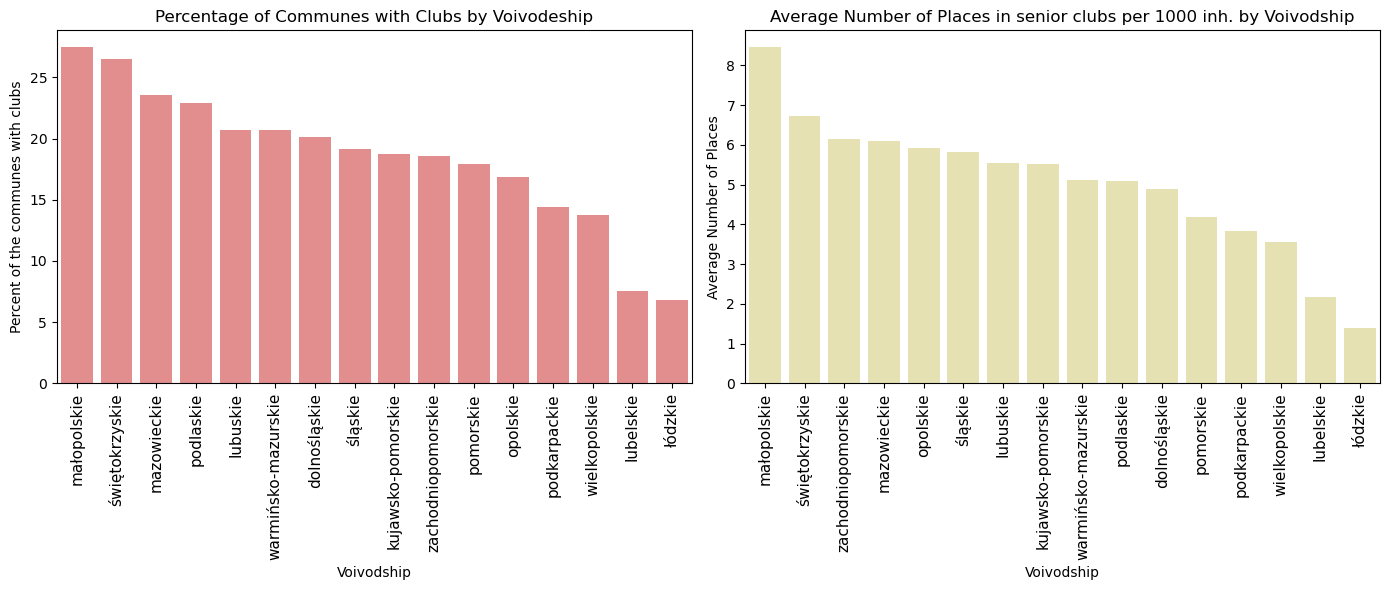

In [57]:
# creating a piece of visualization for the table above

# creating a figure with two plots, 1 row x 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# first plot: percentage of communes with clubs across voivodships
sns.barplot(data=voivodeship_data, x='voi_name', y='percent_commune_with_clubs', ax=axs[0], color = 'lightcoral')
axs[0].set_xticks(range(len(voivodeship_data['voi_name'])))
axs[0].set_xticklabels(voivodeship_data['voi_name'], rotation=90, fontsize=11)
axs[0].set_title('Percentage of Communes with Clubs by Voivodeship')
axs[0].set_ylabel('Percent of the communes with clubs')
axs[0].set_xlabel('Voivodship')

# sorting the data by average number of places per 1000 inhabitants to create a barchart with sorted values
voivodeship_data_sorted_by_avg_num=voivodeship_data.sort_values('avg_number_of_places', ascending=False)

# second plot: average number of places in senior clubs across voivodships
sns.barplot(data=voivodeship_data_sorted_by_avg_num, x='voi_name', y='avg_number_of_places', ax=axs[1], color = 'palegoldenrod')
axs[1].set_xticks(range(len(voivodeship_data_sorted_by_avg_num['voi_name'])))
axs[1].set_xticklabels(voivodeship_data_sorted_by_avg_num['voi_name'], rotation=90, fontsize=11)
axs[1].set_title('Average Number of Places in senior clubs per 1000 inh. by Voivodship')
axs[1].set_xlabel('Voivodship')
axs[1].set_ylabel('Average Number of Places')

plt.tight_layout()
plt.show()


## Type of the commune comparison
This section summarizes the differences in club availability based on commune types.

In [59]:
# calculating aggregated values by commune type
commune_types = df.groupby('commune_type_label').agg(
    number_of_communes = ('commune_type', 'count'),
    communes_with_clubs=('number_of_places_per_1000_inh', lambda x: (x > 0).sum()),
    population = ('commune_population', 'sum'),
    number_of_places_sum = ('number_of_places', 'sum'),
    avg_number_of_places_per_commune=('number_of_places', 'mean')
).reset_index()

# calculating percent of communes with clubs
commune_types['percent_commune_with_clubs'] = round((
    commune_types['communes_with_clubs'] / commune_types['number_of_communes'] * 100
), 2)

# calculating number of places per 10 000 inhabitants - I increased the reference point becuase the population aggregated in three groups increased vastly.
commune_types['number_of_places_per_10000_inh'] = round((
    commune_types['number_of_places_sum'] / commune_types['population'] * 10000
), 2)

commune_types

,commune_type_label,number_of_communes,communes_with_clubs,population,number_of_places_sum,avg_number_of_places_per_commune,percent_commune_with_clubs,number_of_places_per_10000_inh
0,mixed,638,118,9025560,3197,5.010972,18.50,3.54
1,rural,1537,252,10890561,6266,4.076773,16.40,5.75
2,urban,302,79,18466455,2671,8.844371,26.16,1.45


- Urban communes more often have clubs than rural communes, and average number of available places in urban communes is bigger than in rural communes.
- Despite that availability normalized by population size is higher in rural communes than in urban communes, the average number of places per commune is lower in rural communes than in urban communes. This corresponds with the fact that share of rural communes with clubs is lower than share of urban communes with clubs.

### Exploring differences depending on the type of the commune

In [62]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

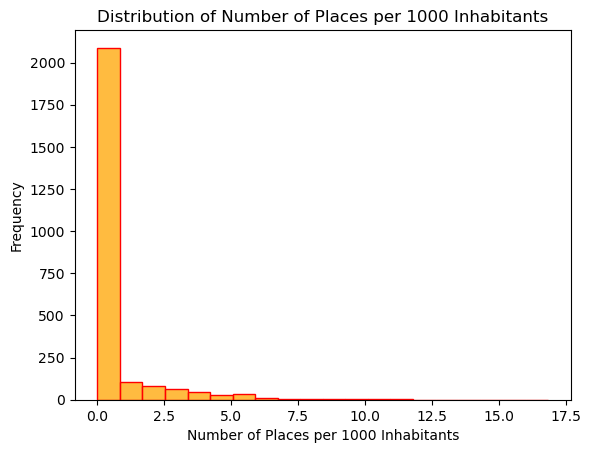

In [70]:
# plotting the distribution of numebr of places in senior clubs per 1000 inhabitants

sns.histplot(df['number_of_places_per_1000_inh'], bins=20, color='orange', edgecolor='red')
plt.title('Distribution of Number of Places per 1000 Inhabitants')
plt.xlabel('Number of Places per 1000 Inhabitants')
plt.ylabel('Frequency')
plt.show()

In [76]:
# performing Shapiro-Wilk Test to formally check the normality. This step is needed to decide which approach to group comparison is appropriate - ANOVA or non-parametric test.

norm_df = df['number_of_places_per_1000_inh']
stat, p = shapiro(norm_df)
print(f'Statistic: {stat}, p-value: {p}')

Statistic: 0.4084853529930115, p-value: 0.0


The Shapiro-Wilk test says clearly the distribution does not follow a normal distribution (p-value = 0.0 < 0.5). Therefore ANOVA will not be a good fit. Non-parametric test like Kruskal-Wallis test will be much better to say if the differences between commune types are significant.

In [79]:
# preparing data for Kruskal-Wallis test
urban = df[df['commune_type_label'] == 'urban']['number_of_places_per_1000_inh']
rural = df[df['commune_type_label'] == 'rural']['number_of_places_per_1000_inh']
mixed = df[df['commune_type_label'] == 'mixed']['number_of_places_per_1000_inh']

# running Kruskal-Wallis test
h_stat, p_val = kruskal(urban, rural, mixed)
print(f"Kruskal-Wallis H-statistic: {h_stat}, p-value: {p_val}")

Kruskal-Wallis H-statistic: 7.859377308249377, p-value: 0.019649789481681484


With p-value = 0.019649789481681484 < 0.05, we can reject null hypothesis at 5% significance level, that there are differences between groups. 
We can assume there is at least one pair with a significant difference.

Next step is Dunn-Bonferroni test to assess which pairs (urban-rural, rural-mixed, urban-mixed) are significantly different.

In [85]:
# preparing data for Dunn-Bonferonni test
dunn_test_data = [df[df['commune_type_label'] == 'urban']['number_of_places_per_1000_inh'],
        df[df['commune_type_label'] == 'rural']['number_of_places_per_1000_inh'],
        df[df['commune_type_label'] == 'mixed']['number_of_places_per_1000_inh']]


In [87]:
# Using the posthoc_dunn() function
p_values = sp.posthoc_dunn(dunn_test_data, p_adjust='holm')

print(p_values)

          1         2         3
1  1.000000  0.015173  0.066710
2  0.015173  1.000000  0.554542
3  0.066710  0.554542  1.000000


In [89]:
# exploring the results of the test in more user-friendly way
print(p_values <0.05)

       1      2      3
1  False   True  False
2   True  False  False
3  False  False  False


The difference in availability of places in senior clubs per 1000 inhabitants is significant for urban and rural communes. This means rural communes has significantly more places per 1000 inhabitants in the communes than town communes (5.75 vs. 1.45 respectively).

## Correlation between population size and offered number of places in the communes

In [95]:
# preparing the data for calculating correlations

df_corr = df[['commune_name', 'commune_type_label', 'commune_population', 'number_of_places']]
df_corr = df_corr.loc[df_corr['number_of_places'] > 0] #I want to include only communes with any clubs. We would assume that communes that participate in the policy will aim to create more places in clubs. 
df_corr=df_corr.sort_values('commune_population', ascending=False)

df_corr.head(16)

,commune_name,commune_type_label,commune_population,number_of_places
2225,Warszawa,urban,1790658,50
902,Kraków,urban,779115,30
2037,Szczecin,urban,401907,60
205,Bydgoszcz,urban,348190,15
1059,Lublin,urban,339784,15
752,Katowice,urban,292774,18
472,Gdynia,urban,246348,40
769,Kielce,urban,194852,70
2367,Zabrze,urban,172360,30
1397,Olsztyn,urban,171979,30


In [141]:
#for exploration purposes i tried variants with excluding the biggest cities from the dataset
#df_corr = df_corr.loc[df_corr['population_commune'] < 50000]

df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 2225 to 1317
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   commune_name        449 non-null    object
 1   commune_type_label  449 non-null    object
 2   commune_population  449 non-null    int64 
 3   number_of_places    449 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 17.5+ KB


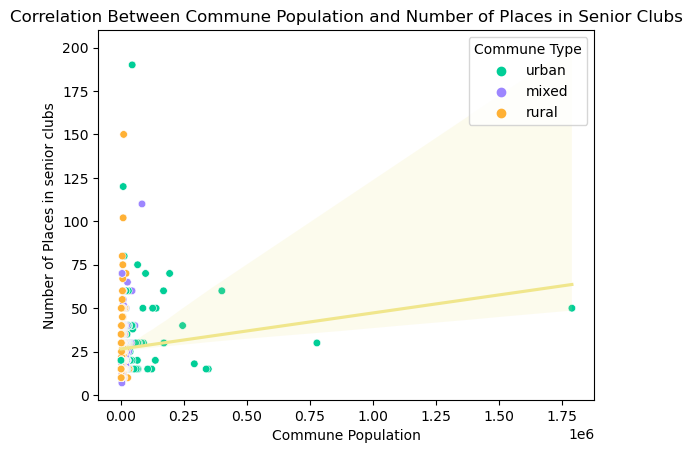

In [129]:
# creating custom palette for the scatterplot
colors = ["#00ce97", "#9d86ff", "#FFB135" ]
customPalette = sns.set_palette(sns.color_palette(colors))

scatter = sns.scatterplot(data=df_corr, x='commune_population', y='number_of_places', hue='commune_type_label', palette=customPalette, s=30)
sns.regplot(x='commune_population', y='number_of_places', data=df_corr, scatter=False, color='khaki')
scatter.legend(title='Commune Type')
plt.title('Correlation Between Commune Population and Number of Places in Senior Clubs')
plt.xlabel('Commune Population')
plt.ylabel('Number of Places in senior clubs')
plt.show()

In [144]:
# calculating pearson correlation coefficient for the whole dataset
corr, _ = pearsonr(df_corr['commune_population'], df_corr['number_of_places'])
print('Pearsons correlation for all: %.3f' % corr)

Pearsons correlation for all: 0.116


In [137]:
# splitting the data by commune type
urban_df = df[df['commune_type_label'] == 'urban']
rural_df = df[df['commune_type_label'] == 'rural']
mixed_df = df[df['commune_type_label'] == 'mixed']

In [139]:
# calculating Pearson correlation coefficient for urban communes
corr_urban, _ = pearsonr(urban_df['commune_population'], urban_df['number_of_places'])
print('Pearsons correlation for urban communes: %.3f' % corr_urban)

# calculating Pearson correlation coefficient for rural communes
corr_rural, _ = pearsonr(rural_df['commune_population'], rural_df['number_of_places'])
print('Pearsons correlation for village communes: %.3f' % corr_rural)

# calculating Pearson correlation coefficient for mixed communes
corr_mixed, _ = pearsonr(mixed_df['commune_population'], mixed_df['number_of_places'])
print('Pearsons correlation for town village communes: %.3f' % corr_mixed)

Pearsons correlation for urban communes: 0.154
Pearsons correlation for village communes: 0.118
Pearsons correlation for town village communes: 0.144


Calculated correlation coefficients indicates weak relationship bewteen the population size and the number of places in senior clubs. This applies both for the dataset as a whole and for individual commune types (urban, rural, mixed).

This low correlation values suggests that population size is not necessarily taken into consideration while creating the offer for older people. However what can be more important in influencing decisions of local authorities is availability of appropriate infrustructure (e.g. buildings) or availability of staff or volunteers.

## References

- [Matplotlib Documentation](https://matplotlib.org/stable/)
- [Seaborn Documentation](https://seaborn.pydata.org/index.html)
- [Pandas Documentation](https://pandas.pydata.org/docs/index.html)
- [SciPy Documentation](https://docs.scipy.org/doc/scipy/index.html)